### <center> This notebook has the postprocess of ERA5 reanalysis data and the following construction of a wind dataset for the tropical band and the coastal bands of the south east and north east pacific.

As an alternative of scatterometer data, the ERA5 winds will be used as reference, so a dataset with this product must be built.

In [1]:
# Imports
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

# Just for supressing an annoying warning
import dask
dask.config.set({"array.slicing.split_large_chunks": False})

In [2]:
# Load ERA5 grid masks (same as 0.25° ASCAT)
mask = xr.open_dataset('data/ERA5_masks.nc')

In [3]:
# Load scatterometer data

# ERA5
path = sorted(glob('data/ERA5/PACIFICBASIN/*.nc'))
def preprocess(data):
    print(data.time[0].dt.strftime('%F').data)
    data = data.rename({'latitude':'lat','longitude':'lon'}).squeeze()
    data = data.resample({'time':'d'}).mean()
    data = data.rename({'u10':'u','v10':'v','ewss':'taux','nsss':'tauy'})
    data = data.sortby('lat').sel(lat=slice(-45,45))
    data = data.sortby('lon').sel(lon=slice(110,291))
    return data.compute()

ERA5 = xr.open_mfdataset(path, parallel=True, concat_dim='time', combine='nested', preprocess=preprocess)
ERA5 = ERA5.sortby('time')
ERA5['ws']  = np.hypot(ERA5.u,ERA5.v)
ERA5['tau'] = np.hypot(ERA5.taux,ERA5.tauy)

2003-05-01
2002-05-01
2010-03-01
2005-05-01
2010-11-01
2008-04-01
2009-08-01
2008-05-01
2008-07-01
2003-07-01
2008-03-01
2017-02-01
2014-01-01
2007-08-01
2006-12-01
2007-11-01
2015-05-01
2003-12-01
2016-10-01
2015-03-01
2001-08-01
2014-10-01
2011-09-01
2016-05-01
2010-02-01
2016-07-01
2017-10-01
2013-08-01
2003-09-01
2016-09-01
2016-08-01
2019-01-01
2016-01-01
2021-08-01
2013-01-01
2020-09-01
2013-06-01
2015-09-01
2022-07-01
2020-12-01
2001-09-01
2013-10-01
2004-11-01
2000-07-01
2015-07-01
2020-03-01
2000-11-01
2004-03-01
2001-04-01
2022-10-01
2007-07-01
2017-06-01
2000-06-01
2020-01-01
2022-05-01
2009-01-01
2002-09-01
2003-06-01
2006-10-01
2005-01-01
2004-04-01
2007-02-01
2017-07-01
2003-08-01
2001-11-01
2019-07-01
2009-02-01
2021-04-01
2004-01-01
2000-05-01
2019-02-01
2011-12-01
2009-12-01
2017-05-01
2014-07-01
2019-04-01
2016-02-01
2019-11-01
2010-10-01
2005-12-01
2016-04-01
2002-06-01
2021-06-012020-05-01

2022-06-01
2019-06-01
2001-03-01
2003-03-01
2010-05-01
2021-10-01
2010-06-01

/home/lucas/miniconda3/envs/forecast/lib/python3.10/site-packages/xarray/core/common.py:1160: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


2004-10-01
2007-01-01
2007-03-01
2014-11-01
2009-10-01
2019-03-01
2007-12-01
2022-02-01
2005-09-01
2005-10-01
2017-12-01
2011-10-01
2008-11-01
2005-06-01
2021-01-01
2013-04-01
2013-07-01
2020-11-01
2017-08-01
2014-04-01
2015-04-01
2000-09-01
2011-01-01
2006-07-01
2001-07-01
2012-09-01
2012-06-01
2003-01-01
2011-03-01
2018-09-01
2014-06-01


---

##### Tropical hovmoller

In [4]:
# Build tropical hovmoller
tropical = ERA5.sel(lat=slice(-3,3),lon=slice(mask.lon.min(),mask.lon.max()))
tropical = tropical.where(mask.tropicalmask==1).mean('lat')
tropical = tropical.dropna('lon') # Drop all land nans
tropical

<xarray.Dataset>
Dimensions:  (time: 8401, lon: 686)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2022-12-31
  * lon      (lon) float32 110.0 110.2 110.5 110.8 ... 280.5 280.8 281.0 281.2
Data variables:
    u        (time, lon) float32 0.2068 -0.04696 -0.07155 ... 3.552 3.994 2.922
    v        (time, lon) float32 -0.6676 -0.3584 -0.3452 ... 3.12 3.584 2.437
    taux     (time, lon) float32 19.6 44.61 55.12 85.71 ... 84.17 90.4 74.55
    tauy     (time, lon) float32 -19.35 -21.05 -12.91 ... 71.39 77.98 70.57
    ws       (time, lon) float32 0.9093 0.4459 0.4147 ... 4.73 5.366 3.805
    tau      (time, lon) float32 44.39 67.84 61.68 89.57 ... 110.4 119.4 102.7

---

##### Build coastal hovmollers

In [5]:
# north
coastnorth = ERA5.sel(lon=slice(230,295), lat=slice(0,50))
coastnorth = coastnorth.where(mask.coastmask_north==1).mean('lon')
coastnorth = coastnorth.dropna('lat')
coastnorth

<xarray.Dataset>
Dimensions:  (time: 8401, lat: 173)
Coordinates:
  * lat      (lat) float64 2.0 2.25 2.5 2.75 3.0 ... 44.0 44.25 44.5 44.75 45.0
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2022-12-31
Data variables:
    u        (time, lat) float32 7.474 7.198 5.936 5.267 ... 3.612 3.936 4.199
    v        (time, lat) float32 4.381 3.816 2.931 2.566 ... 0.8417 0.9364 1.006
    taux     (time, lat) float32 349.3 338.9 275.8 207.1 ... 78.5 86.66 96.24
    tauy     (time, lat) float32 189.6 167.6 142.7 103.6 ... 17.12 19.58 22.97
    ws       (time, lat) float32 8.675 8.157 6.622 5.863 ... 3.732 4.062 4.332
    tau      (time, lat) float32 398.4 379.0 311.3 232.0 ... 81.33 89.49 99.35

In [6]:
# south
coastsouth = ERA5.sel(lon=slice(260,295), lat=slice(-50,0))
coastsouth = coastsouth.where(mask.coastmask_south==1).mean('lon')
coastsouth = coastsouth.dropna('lat').sortby('lat', ascending=False)
coastsouth

<xarray.Dataset>
Dimensions:  (time: 8401, lat: 172)
Coordinates:
  * lat      (lat) float64 -2.25 -2.5 -2.75 -3.0 ... -44.25 -44.5 -44.75 -45.0
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2022-12-31
Data variables:
    u        (time, lat) float32 3.554 3.833 4.265 3.962 ... 2.312 2.162 1.977
    v        (time, lat) float32 5.319 5.529 4.94 1.313 ... -5.596 -6.123 -5.828
    taux     (time, lat) float32 112.8 129.0 140.4 ... 1.615e+03 1.876e+03
    tauy     (time, lat) float32 178.0 195.1 170.5 ... -2.333e+03 -2.949e+03
    ws       (time, lat) float32 6.426 6.771 6.603 4.322 ... 6.133 6.561 6.232
    tau      (time, lat) float32 211.8 235.6 223.7 ... 2.858e+03 3.517e+03

---

##### Add coordinate and metadata

In [7]:
# Import some common functions from utils.py file
from utils import haversine, distances, coastcoords, add_hovmoller_coordinatedata
ntropical,ncoastnorth,ncoastsouth = add_hovmoller_coordinatedata(tropical,coastnorth,coastsouth,mask,
                                                                 ['time','distance','lat','lon','index','u','v','taux','tauy','ws','tau'])
tropical   = ntropical.copy()
coastnorth = ncoastnorth.copy()
coastsouth = ncoastsouth.copy()
del ntropical, ncoastnorth, ncoastsouth

In [8]:
dummy = xr.open_dataset('data/ERA5/PACIFICBASIN/WINDS_Y2000M01.nc') # dummy dataset with some attributes

# Global attributes
tropical_attrs   = {'name':'Tropical Hovmoller of ERA5 winds',
                    'institution':'Centro de estudios avanzados en zonas aridas (CEAZA)',
                    'description':'Wind average along the tropical band (2°S - 2°N)',
                    'author':'Lucas Glasner',
                    'contact':'lucas.glasner@ceaza.cl',
                    'long_name':'DT merged all satellites Global Ocean Gridded SSALTO/DUACS Sea Surface Height L4 product and derived variables'}
coastnorth_attrs = {'name':'Coastal Hovmoller of ERA5 winds for the North East Pacific',
                    'institution':'Centro de estudios avanzados en zonas aridas (CEAZA)',
                    'description':'Wind average along a coastal band of 1deg latitude',
                    'author':'Lucas Glasner',
                    'contact':'lucas.glasner@ceaza.cl'}
coastsouth_attrs = {'name':'Coastal Hovmoller of ERA5 winds for the South East Pacific',
                    'institution':'Centro de estudios avanzados en zonas aridas (CEAZA)',
                    'description':'Wind average along a coastal band of 1deg latitude',
                    'author':'Lucas Glasner',
                    'contact':'lucas.glasner@ceaza.cl'}

# Common variable attributes
u_attrs          = dummy.u10.attrs
v_attrs          = dummy.v10.attrs
taux_attrs       = dummy.ewss.attrs
tauy_attrs       = dummy.nsss.attrs
tau_attrs        = {'units':'N m**-2 s','long_name':'Turbulent surface stress magnitude',
                    'standard_name':'surface downward turbulent stress'}
ws_attrs         = {'units':'m s-1', 'long_name':'wind speed at 10m', 'standard_name':'surface wind speed'}
lon_attrs        = dummy.longitude.attrs
lat_attrs        = dummy.latitude.attrs
time_attrs       = dummy.time.attrs
index_attrs      = {'long_name':'Position along the spatial dimension of the hovmoller grid',
                    'short_name':'index',
                    'units':'(-)'}
distance_attrs   = {'long_name':'Distance along the spatial dimension of the hovmoller grid',
                    'short_name':'distance',
                    'units':'km'}

In [9]:
# Assign attributes 
tropical.attrs          = tropical_attrs
tropical.u.attrs        = u_attrs
tropical.v.attrs        = v_attrs
tropical.taux.attrs     = taux_attrs
tropical.tauy.attrs     = tauy_attrs
tropical.tau.attrs      = tau_attrs
tropical.ws.attrs       = ws_attrs
tropical.lon.attrs      = lon_attrs
tropical.lat.attrs      = lat_attrs
tropical.index.attrs    = index_attrs
tropical.distance.attrs = distance_attrs

coastnorth.attrs          = coastnorth_attrs
coastnorth.u.attrs        = u_attrs
coastnorth.v.attrs        = v_attrs
coastnorth.taux.attrs     = taux_attrs
coastnorth.tauy.attrs     = tauy_attrs
coastnorth.tau.attrs      = tau_attrs
coastnorth.ws.attrs       = ws_attrs
coastnorth.lon.attrs      = lon_attrs
coastnorth.lat.attrs      = lat_attrs
coastnorth.index.attrs    = index_attrs
coastnorth.distance.attrs = distance_attrs

coastsouth.attrs          = coastsouth_attrs
coastsouth.u.attrs        = u_attrs
coastsouth.v.attrs        = v_attrs
coastsouth.taux.attrs     = taux_attrs
coastsouth.tauy.attrs     = tauy_attrs
coastsouth.tau.attrs      = tau_attrs
coastsouth.ws.attrs       = ws_attrs
coastsouth.lon.attrs      = lon_attrs
coastsouth.lat.attrs      = lat_attrs
coastsouth.index.attrs    = index_attrs
coastsouth.distance.attrs = distance_attrs

In [12]:
# Save data into disk
tropical.to_netcdf('./data/HOVMOLLERS/ERA5_hovmoller_tropical_2000-2022.nc')
coastnorth.to_netcdf('./data/HOVMOLLERS/ERA5_hovmoller_coastnorth_2000-2022.nc')
coastsouth.to_netcdf('./data/HOVMOLLERS/ERA5_hovmoller_coastsouth_2000-2022.nc')

Text(0, 0.5, 'Tropical - South America Coast')

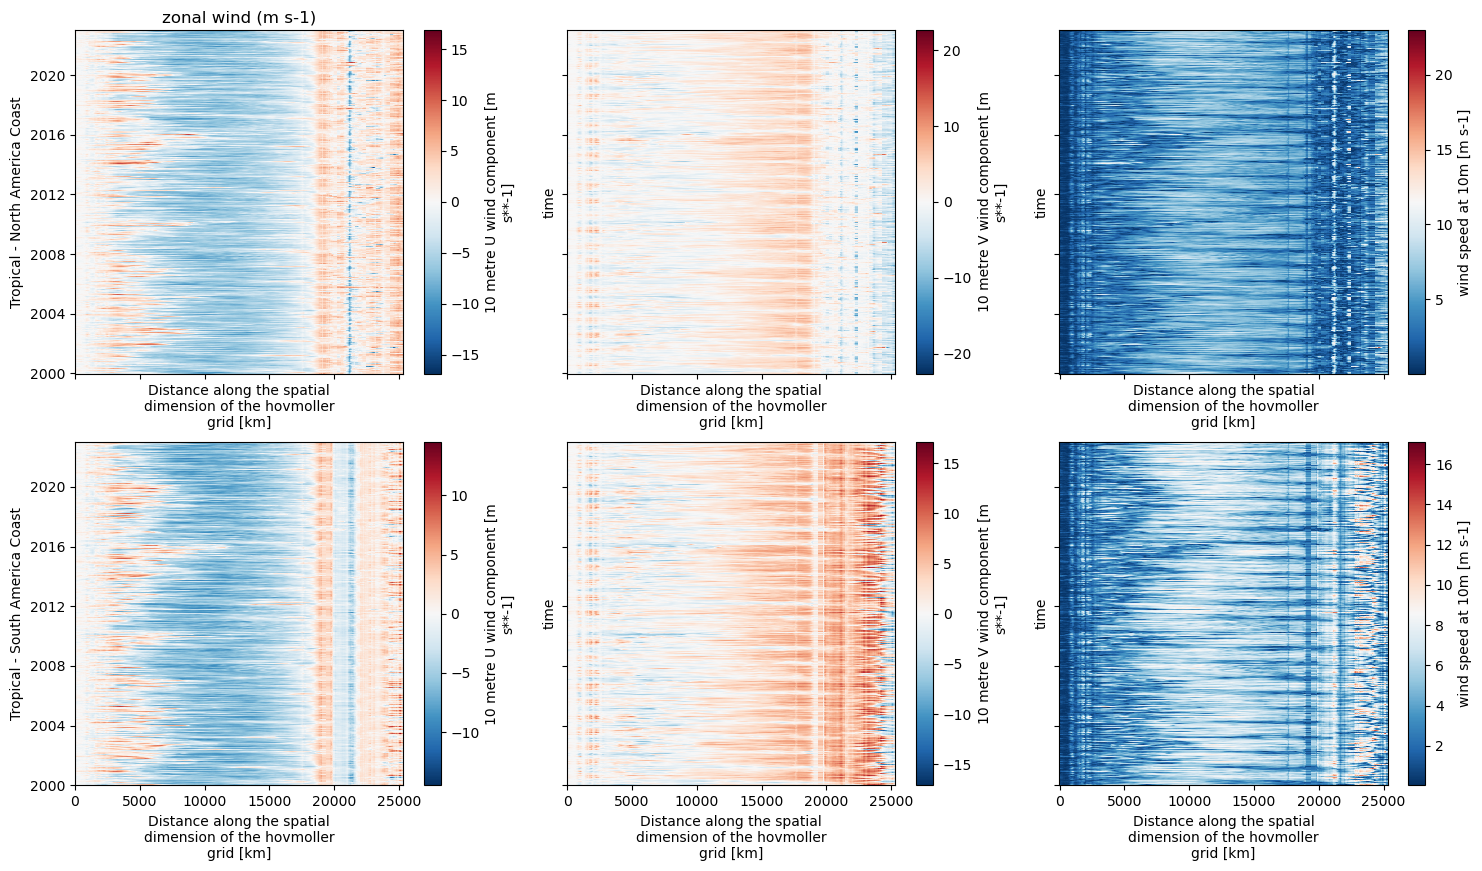

In [11]:
# Quicklook to the hovmollers
fig, ax = plt.subplots(2,3, figsize=(18,10), dpi=100, facecolor='w',
                       sharex=True, sharey=True)

xr.concat([tropical,coastnorth], 'distance').u.plot(ax=ax[0,0], cmap='RdBu_r')
xr.concat([tropical,coastsouth], 'distance').u.plot(ax=ax[1,0], cmap='RdBu_r')

xr.concat([tropical,coastnorth], 'distance').v.plot(ax=ax[0,1], cmap='RdBu_r')
xr.concat([tropical,coastsouth], 'distance').v.plot(ax=ax[1,1], cmap='RdBu_r')

xr.concat([tropical,coastnorth], 'distance').ws.plot(ax=ax[0,2], cmap='RdBu_r')
xr.concat([tropical,coastsouth], 'distance').ws.plot(ax=ax[1,2], cmap='RdBu_r')


ax[0,0].set_title('zonal wind (m s-1)')

ax[0,0].set_ylabel('Tropical - North America Coast')
ax[1,0].set_ylabel('Tropical - South America Coast')